# Welcome to Jupyter!

This repo contains an introduction to [Jupyter](https://jupyter.org) and [IPython](https://ipython.org).

Outline of some basics:

* [Notebook Basics](../examples/Notebook/Notebook%20Basics.ipynb)
* [IPython - beyond plain python](../examples/IPython%20Kernel/Beyond%20Plain%20Python.ipynb)
* [Markdown Cells](../examples/Notebook/Working%20With%20Markdown%20Cells.ipynb)
* [Rich Display System](../examples/IPython%20Kernel/Rich%20Output.ipynb)
* [Custom Display logic](../examples/IPython%20Kernel/Custom%20Display%20Logic.ipynb)
* [Running a Secure Public Notebook Server](../examples/Notebook/Running%20the%20Notebook%20Server.ipynb#Securing-the-notebook-server)
* [How Jupyter works](../examples/Notebook/Multiple%20Languages%2C%20Frontends.ipynb) to run code in different languages.

You can also get this tutorial and run it on your laptop:

    git clone https://github.com/ipython/ipython-in-depth

Install IPython and Jupyter:

with [conda](https://www.anaconda.com/download):

    conda install ipython jupyter

with pip:

    # first, always upgrade pip!
    pip install --upgrade pip
    pip install --upgrade ipython jupyter

Start the notebook in the tutorial directory:

    cd ipython-in-depth
    jupyter notebook

In [3]:
import sys
!{sys.executable} -m pip install SPARQLWrapper
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import numpy as np
import datetime
import func_lib
import inspect

endpoint_url = "https://query.wikidata.org/sparql"
item = "item"


class FunctionWithSignature:
    """Specific for function applied to the entire relation,
        name is the name of the function (str)
        typeSignature is the required list of types in a relation,
        func is the function to be applied to the entire relation."""
    def __init__(self, name, typeSignature, func):
        self.func = func
        self.typeSignature = typeSignature
        self.name = name

    def invoke(self, df):
        return self.func(df)
    
    def showTypeRequest(self):
        return self.typeSignature

class Relation:
    """
    The class returned when createRelation is called.
    It contains string field with query.
    We call Relation.query when we need to do the query.
    """

    def __init__(self, entity_id: str, property_id: str, isSubject: bool, rowVerbose: bool,
                 colVerbose: bool, time_property: str, time: str, name: str, label: bool, limit=10000, subclass=False, showid=False, reconstruct={}):
        if bool(reconstruct):
            self.entity_id = reconstruct["entity_id"]
            self.query_str = reconstruct["query_str"]
            self.dic = reconstruct["dic"]
            self.result_dic = reconstruct["result_dic"]
            self.df = reconstruct["df"]
            self.count = reconstruct["count"]
            self.time_property = reconstruct["time_property"]
            self.time = reconstruct["time"]
            self.limit = reconstruct["limit"]
            self.subclass = reconstruct["subclass"]
            self.focus = reconstruct["focus"]
        else:
            self.entity_id = entity_id
            self.query_str = ""
            self.dic = {}
            self.result_dic = {"Entity ID": []}
            self.df = pd.DataFrame()
            self.count = 0
            self.time_property = time_property
            self.time = time
            self.limit = limit
            self.subclass = subclass
            self.focus = "Entity ID"
            if property_id:
                self.extend(property_id, isSubject, name, rowVerbose, colVerbose, limit, time_property, time, label, subclass, showid)

    def generate_html(self, name: str):
        html = (self.df).to_html()
        text_file = open(name, "w", encoding='utf-8')
        text_file.write(html)
        text_file.close()

    def query(self, require=None):
        if self.query_str == "":
            self.result_dic = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
            return self.result_dic
        results = get_results(endpoint_url, self.query_str)
        result_dict = {"Entity ID": ['http://www.wikidata.org/entity/' + str(self.entity_id)]}
        for i in range(1, self.count + 1):
            result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id']] = []
            if self.dic[i]["colVerbose"]:
                result_dict[self.dic[i]["name"] + '_rank_' + self.dic[i]['property_id'] + '_rank'] = []
                for key, value in self.dic[i]["property_name_dic"].items():
                    result_dict[
                        self.dic[i]["name"] + "_" + value + '_' + self.dic[i]['property_id'] + '_' + str(key)] = []
                for key, value in self.dic[i]["ref_dic"].items():
                    result_dict[self.dic[i]["name"] + "_ref_" + self.dic[i]['property_id'] + '_' + str(key)] = []

            if self.dic[i]["label"]:
                result_dict[self.dic[i]["name"] + '_' + self.dic[i]['property_id'] + 'Label'] = []

        for result in results['results']['bindings']:
            for key, value in result_dict.items():
                if key in result.keys():
                    result_dict[key].append(result[key]['value'])
                else:
                    result_dict[key].append('NA')
        result_dict["Entity ID"] = ['http://www.wikidata.org/entity/' + str(self.entity_id)] * len(
            result_dict[self.dic[self.count]["name"] + '_' + self.dic[self.count]["property_id"]])
        result_dict["Basic ID"] = [str(self.entity_id)] * len(
            result_dict[self.dic[self.count]["name"] + '_' + self.dic[self.count]["property_id"]])
        self.result_dic = result_dict
        self.df = pd.DataFrame.from_dict(self.result_dic)
        for i in range(1, self.count + 1):
            if self.dic[i]["colVerbose"] and not self.dic[i]["rowVerbose"]:
                col = self.dic[i]['name'] + '_rank_' + self.dic[i]['property_id'] + '_rank'
                if any(self.df[col] == 'http://wikiba.se/ontology#PreferredRank'):
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#PreferredRank']
                else:
                    self.df = self.df.loc[self.df[col] == 'http://wikiba.se/ontology#NormalRank']
        for i in range(1, self.count + 1):
            if self.dic[i]["showid"]:
                self.df[self.dic[i]["name"] + '_' + self.dic[i]['property_id'] + '_basic'] = self.df[self.dic[i]["name"] + '_' + self.dic[i]['property_id']].apply(lambda x: x.split('/')[-1])
        self.df = pd.DataFrame(data=self.df)
        return self.df

    def extend(self, property_id: str, isSubject: bool, name: str, rowVerbose=False, colVerbose=False, limit=None,
               time_property=None, time=None, search=None, label=False, subclass=False, showid=False):
        self.count += 1
        self.dic[self.count] = {}
        self.dic[self.count]["name"] = name
        self.dic[self.count]["focus"] = self.focus
        self.dic[self.count]["property_id"] = property_id
        self.dic[self.count]["isSubject"] = isSubject
        self.dic[self.count]["limit"] = limit
        self.dic[self.count]["rowVerbose"] = rowVerbose
        self.dic[self.count]["colVerbose"] = colVerbose
        self.dic[self.count]['time_property'] = time_property
        self.dic[self.count]['time'] = time
        self.dic[self.count]['search'] = search
        self.dic[self.count]['label'] = label
        self.dic[self.count]['subclass'] = subclass
        self.dic[self.count]['showid'] = showid
        # subclass is specific to P31, when subclass is true, we get intance of all subclasses of the entity
        if rowVerbose or colVerbose:
            self.dic[self.count]["property_name_dic"], self.dic[self.count][
                "ref_dic"] = self.search_property_for_verbose()
        if time_property and time:
            self.time_property = time_property
            self.time = time
        if limit:
            self.limit = limit
        self.query_str = self.define_query_relation()

    def changeFocus(self, name="Entity ID"):
        self.focus = name

    def extendWithFunction(self, objcolumn, func, name):
        if type(func) == str:
            if func.startswith('F'):
                try:
                    func_id = int(func[1:])
                    if func_id >= func_lib.func_num():
                        raise Exception("Not available.")
                    else:
                        func = func_lib.func_list[func_id]
                except:
                    raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
            else:
                raise Exception("Not a valid function id, a valid function id should be 'Fn', n is an integer.")
        else:
            sig = inspect.signature(func)
            params = sig.parameters
            num_params = len(params)
            num_required = 0
            for key, value in params.items():
                if value.default is inspect._empty and key != 'self':
                    num_required += 1
            if isinstance(objcolumn, list):
                if len(objcolumn) > num_params:
                    if num_params == 1 or num_params == 0:
                        raise Exception("Too many arguments, the function only takes " + str(num_params) + " argument.")
                    else:
                        raise Exception("Too many arguments, the function only takes " + str(num_params) + " arguments.")
                if len(objcolumn) < num_required:
                    raise Exception("Too little arguments, the function requires at least " + str(num_required) + " arguments.")
                count = 0
                for key, value in params.items():
                    if value.default is inspect._empty and key != 'self':
                        if (not value.annotation is inspect._empty) and ((isinstance(value.annotation, WikiDataProperty) and not objcolumn[count].split('_')[-1] in value.annotation.type_list) or
                        (not isinstance(value.annotation, WikiDataProperty) and (not isinstance(self.df[objcolumn[count]][0], value.annotation)))):
                            raise Exception("Please make sure the inputs meet the requirements of the arguments.")
                        count+=1
                self.df[name] = self.df[objcolumn].apply(lambda x: func(*x), axis=1)
            else:
                if num_required > 1:
                    raise Exception("Too little arguments, the function requires at least " + str(num_required) + " arguments.")
                if num_params < 1:
                    raise Exception("The function doesn't take any argument.")
                type_required = None
                for key, value in params.items():
                    if value.default is inspect._empty and key != 'self':
                        type_required = value.annotation
                if isinstance(self.df[objcolumn][0], type_required) or type_required is inspect._empty:
                    self.df[name] = self.df[objcolumn].apply(func)
                elif isinstance(type_required, WikiDataProperty) and objcolumn.split('_')[-1] in type_required.type_list:
                    self.df[name] = self.df[objcolumn].apply(func)
                else:
                    raise Exception("Please make sure the input meets the requirement of the argument.")

    def applyFunction(self, objcolumn, func):
        # func: FunctionWithSignature
        num_params = len(func.typeSignature)
        if len(objcolumn) != num_params:
            if num_params == 1 or num_params == 0:
                raise Exception("The function only takes Dataframe with " + str(num_params) + " column.")
            else:
                raise Exception("The function only takes Dataframe with " + str(num_params) + " columns.")
        count = 0
        # type check
        for value in func.typeSignature:
            if (isinstance(value, WikiDataProperty) and not objcolumn[count].split('_')[-1] in value.type_list) or (not isinstance(value, WikiDataProperty) and (not isinstance(self.df[objcolumn[count]][0], value))):
                raise Exception("Please make sure the input Dataframe meets the requirements of the arguments.")
            count+=1
        #        
        func.invoke(self.df[objcolumn])
        
    def define_query_relation(self):
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.count < 1:
            return None
        focusChanges = 0
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                if self.dic[i]["search"] is None and not self.dic[i]["isSubject"]:
                        rdf_triple += """OPTIONAL {"""
                if self.dic[i]["focus"] == "Entity ID":
#                     if self.dic[i]["search"] is None:
#                         rdf_triple += """OPTIONAL {"""
                    rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    rdf_triple += """?""" + self.dic[i]["focus"] + """ p:""" + self.dic[i][
                        'property_id'] + """ ?statement_""" + str(i) + """. """ \
                                  + """?statement_""" + str(i) + """ ps:""" + self.dic[i][
                                      'property_id'] + """ ?""" + \
                                  self.dic[i]['name'] \
                                  + """_""" + self.dic[i]['property_id'] + """. """
                for key, value in self.dic[i]["property_name_dic"].items():
                    rdf_triple += """OPTIONAL { """ + """?statement_""" + str(i) + """ pq:""" + str(key) \
                                  + """ ?""" + self.dic[i]['name'] + """_""" + value + """_""" + self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                for key, value in self.dic[i]["ref_dic"].items():
                    rdf_triple += """OPTIONAL { ?statement_""" + str(
                        i) + """ prov:wasDerivedFrom ?refnode_""" + str(
                        i) + """. ?refnode_""" + str(i) \
                                  + """ pr:""" + str(key) + """ ?""" + self.dic[i]['name'] + """_ref_""" + \
                                  self.dic[i][
                                      'property_id'] + """_""" + str(key) + """.} """
                rdf_triple += """OPTIONAL { ?statement_""" + str(i) + """ wikibase:rank ?""" + self.dic[i][
                    'name'] + """_rank_""" + self.dic[i]['property_id'] + """_rank. } """
            # none-verbose version
            else:
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        if not self.dic[i]['subclass']:
                            rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i][
                                              "property_id"] + """ wd:""" + self.entity_id + """. """
                        else:
                            if self.dic[i]['property_id'] == "P31":
                                rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                    'property_id'] + """ wdt:""" + self.dic[i][
                                                  "property_id"] + """ ?subclasses. """
                                rdf_triple += """?subclasses wdt:P279+ wd:""" + self.entity_id + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """. """
                else:
                    if self.dic[i]["isSubject"]:
                        if not self.dic[i]['subclass']:
                            rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + self.dic[i][
                                              'focus'] + """. """
                        else:
                            if self.dic[i]['property_id'] == "P31":
                                rdf_triple += """?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                'property_id'] + """ wdt:""" + self.dic[i]["property_id"] + """ ?subclasses. """
                                rdf_triple += """?subclasses wdt:P279+ ?""" + self.dic[i]['focus'] + """. """
                    else:
                        if self.dic[i]["search"] is None:
                            rdf_triple += """OPTIONAL {"""
                        rdf_triple += """?""" + self.dic[i]['focus'] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i][
                                          'property_id'] + """. """
            if not self.dic[i]["isSubject"]:
                if i < self.count and self.dic[i]["focus"] != self.dic[i + 1]["focus"] and self.dic[i]["search"] is None:
                    focusChanges += 1
                elif self.dic[i]["search"] is None:
                    rdf_triple += """} """
                
        for i in range(focusChanges):
            rdf_triple += """} """
        for i in range(1, self.count + 1):
            if self.dic[i]['search'] is not None and self.dic[i]["search"] != '!NA':
                if isinstance(self.dic[i]['search'], tuple):
                    if isinstance(self.dic[i]['search'][0], str):
                        rdf_triple += """FILTER (YEAR(?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                            'property_id'] + """) >= """ + \
                                      self.dic[i]['search'][0] + """ && YEAR(?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """) <= """ + self.dic[i]['search'][
                                          1] + """) """
                    else:
                        rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i]['property_id'] + \
                                      """ >= """ + str(self.dic[i]['search'][0]) + """ && ?""" + self.dic[i]['name'] + \
                                      """_""" + self.dic[i]['property_id'] + """ <= """ + str(
                            self.dic[i]['search'][1]) + """) """
                else:
                    rdf_triple += """FILTER (?""" + self.dic[i]['name'] + """_""" + self.dic[i][
                        'property_id'] + """ = """ + \
                                  """wd:""" + self.dic[i]['search'] + """) """
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                          ?pubdateStatement ps:""" + self.time_property + """ ?date	
                          FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT"""
        for i in range(1, self.count + 1):
            if self.dic[i]["rowVerbose"] or self.dic[i]["colVerbose"]:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
                for key, value in self.dic[i]["property_name_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_""" + value + """_""" + self.dic[i][
                        'property_id'] + """_""" + str(key)
                for key, value in self.dic[i]["ref_dic"].items():
                    query += """ ?""" + self.dic[i]["name"] + """_ref_""" + self.dic[i]['property_id'] + """_""" + str(
                        key)
                query += """ ?""" + self.dic[i]["name"] + """_rank_""" + self.dic[i]['property_id'] + """_rank"""
            else:
                query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id']
                if self.dic[i]["label"]:
                    query += """ ?""" + self.dic[i]["name"] + """_""" + self.dic[i]['property_id'] + """Label"""
        query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
        return query

    def search_property_for_verbose(self):
        property_to_name = {}
        ref_to_name = {}
        rdf_triple, time_filter, limit_statement = """""", """""", """"""
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            for i in range(1, self.count):
                if self.dic[i]["focus"] == "Entity ID":
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ wd:""" + self.entity_id + """ ."""
                    else:
                        rdf_triple += """wd:""" + self.entity_id + """ wdt:""" + self.dic[i]["property_id"] + """ ?""" + \
                                      self.dic[i]["name"] + """ ."""
                else:
                    last = self.dic[i]["focus"].rfind('_')
                    focus = self.dic[i]["focus"][:last]
                    if self.dic[i]["isSubject"]:
                        rdf_triple += """?""" + self.dic[i]["name"] + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + focus + """ ."""
                    else:
                        rdf_triple += """?""" + focus + """ wdt:""" + self.dic[i][
                            "property_id"] + """ ?""" + self.dic[i]["name"] + """ ."""
            if self.dic[self.count]["focus"] == "Entity ID":
                rdf_triple += """wd:""" + self.entity_id + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
            else:
                last = self.dic[self.count]["focus"].rfind('_')
                focus = self.dic[self.count]["focus"][:last]
                rdf_triple += """?""" + focus + """ p:""" + self.dic[self.count][
                    'property_id'] + """ ?statement.""" + \
                              """?statement """ + """ps:""" + self.dic[self.count]['property_id'] + """ ?item.""" + \
                              """?statement """ + """?pq """ + """?obj.""" + \
                              """?qual wikibase:qualifier ?pq.""" + \
                              """OPTIONAL{ ?statement prov:wasDerivedFrom ?refnode. ?refnode ?pr ?r.}"""
        if self.time_property is not None:
            time_filter = """?""" + self.dic[1]["name"] + """ p:""" + self.time_property + """ ?pubdateStatement.	
                                  ?pubdateStatement ps:""" + self.time_property + """ ?date	
                                  FILTER (YEAR(?date) = """ + self.time + """)"""
        if self.limit is not None:
            limit_statement = """LIMIT """ + str(self.limit)
        label_statement = """Service wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }"""
        query = """SELECT DISTINCT """
        if self.dic[self.count]["rowVerbose"] or self.dic[self.count]["colVerbose"]:
            query += """?item""" + """ ?qual""" + """ ?qualLabel""" + """ ?obj """ + """?pr ?prLabel"""
            query += """ WHERE {""" + rdf_triple + time_filter + label_statement + """} """ + limit_statement
            query_result = get_results(endpoint_url, query)
            for result in query_result['results']['bindings']:
                if 'qual' in result:
                    property_to_name[result['qual']['value'].split('/')[-1]] = result['qualLabel']['value'].replace(' ',
                                                                                                                    '_')
                if 'pr' in result:
                    ref_to_name[result['pr']['value'].split('/')[-1]] = result['prLabel']['value'].replace(' ', '_')
        else:
            query += """?""" + self.dic[self.count]["name"] + """ """
        return property_to_name, ref_to_name

    def __str__(self):
        return str(self.df)

    def __getattr__(self, col_name):
        if col_name in self.df.columns:
            return self.df[col_name]
        else:
            print(col_name + " has not been found.")
            return None

        
class WikiDataType:
    def __init__(self, entity_id: list):
        self.entity_id = entity_id
        self.type_list = []
        for entity in self.entity_id:
            query_str = """SELECT DISTINCT ?s WHERE {?s wdt:P279+ wd:""" + entity + """. Service wikibase:label { 
                bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }}"""
            results = get_results(endpoint_url, query_str)
            self.type_list.append(entity)
            for result in results['results']['bindings']:
                self.type_list.append(result['s']['value'].split('/')[-1])

    def __instancecheck__(self, inst):
        inst = inst.split('/')[-1]
        type_list = []
        query_str = """SELECT DISTINCT ?s WHERE {wd:""" + inst + """ wdt:P31 ?s. Service wikibase:label { 
            bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en" }}"""
        results = get_results(endpoint_url, query_str)
        for result in results['results']['bindings']:
            type_list.append(result['s']['value'].split('/')[-1])
        for type_temp in type_list:
            if type_temp in self.type_list:
                return True
        return False

class WikiDataProperty:
    def __init__(self, property_id: list):
        self.property_id = property_id
        self.type_list = []
        for property_id in self.property_id:
            self.type_list.append(property_id.split('/')[-1])
    
def createRelation(entity_id: str, property_id=None, isSubject=None, rowVerbose=None, colVerbose=None,
                   time_property=None, time=None, name=None, label=False, limit=None, subclass=False):
    if property_id and not name:
        print("Please specify the name of the first column")
        return None
    return Relation(entity_id, property_id, isSubject, rowVerbose, colVerbose, time_property, time, name, label, limit, subclass)

def get_Firstname(name: str):
    return name.split(' ')[0]

def get_Lastname(name: str):
    return name.split(' ')[-1]

def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def get_name(id: str):
    query = """PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> 	
                PREFIX wd: <http://www.wikidata.org/entity/> 	
                select  *	
                where {	
                wd:""" + id + """ rdfs:label ?label .	
                FILTER (langMatches( lang(?label), "EN" ) )	
                } 	
                LIMIT 1"""
    results = get_results(endpoint_url, query)
    result = ''
    for res in results["results"]["bindings"]:
        result = res['label']['value']
    return result


# National Parks example

In [35]:
entity_subclass = 'national_park'
qnum = 'Q34918903' # "National Park of the United States"
parks = createRelation(qnum, label=True)
parks.extend('P31', True, 'entity_subclass', label=True) # extend via property P31 = is instance of

parks.changeFocus('entity_subclass_P31')
parks.extend('P17', False, 'Country',label=True, search="Q30") # extend via property P17 = is in country
# parks.extend('P131', False, 'State', label=True)
parks.extend('P625', False, 'Lon_Lat')
parks.extend('P571', False, 'Inception')
parks.query()

print('There are %s instances of %s in the US.' % (str(len(parks.df)), entity_subclass))

There are 77 instances of national_park in the US.


In [36]:
parks.df

,Entity ID,entity_subclass_P31,entity_subclass_P31Label,Country_P17,Country_P17Label,Lon_Lat_P625,Inception_P571,Basic ID
0,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q836264,Kobuk Valley National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-159.283333333 67.55),1980-12-02T00:00:00Z,Q34918903
1,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q205952,Hawaiʻi Volcanoes National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-155.12361 19.40083),1916-01-01T00:00:00Z,Q34918903
2,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q841503,Kenai Fjords National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-150.10857 59.81571),1980-01-01T00:00:00Z,Q34918903
3,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q866080,Biscayne National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-80.18096924 25.50185493),1980-06-28T00:00:00Z,Q34918903
4,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q305880,Black Canyon of the Gunnison National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-107.716666666 38.566666666),1933-03-02T00:00:00Z,Q34918903
...,...,...,...,...,...,...,...,...
72,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q605657,Gates of the Arctic National Park and Preserve,http://www.wikidata.org/entity/Q30,United States of America,Point(-153.3 67.7833),1980-01-01T00:00:00Z,Q34918903
73,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q217136,Denali National Park and Preserve,http://www.wikidata.org/entity/Q30,United States of America,Point(-150.3 63.2),1917-01-01T00:00:00Z,Q34918903
74,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q239304,Crater Lake National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-122.148055555 42.911944444),1902-01-01T00:00:00Z,Q34918903
75,http://www.wikidata.org/entity/Q34918903,http://www.wikidata.org/entity/Q129902,Capitol Reef National Park,http://www.wikidata.org/entity/Q30,United States of America,Point(-111.167 38.2),1937-08-02T00:00:00Z,Q34918903


In [37]:
parks.df = parks.df[20:40].reset_index(drop=True)

In [38]:
createArrowMapVis = FunctionWithSignature(
    'name',
    [WikiDataProperty(['P571']),
     WikiDataProperty(['P625']),str],
    arrow_map
)

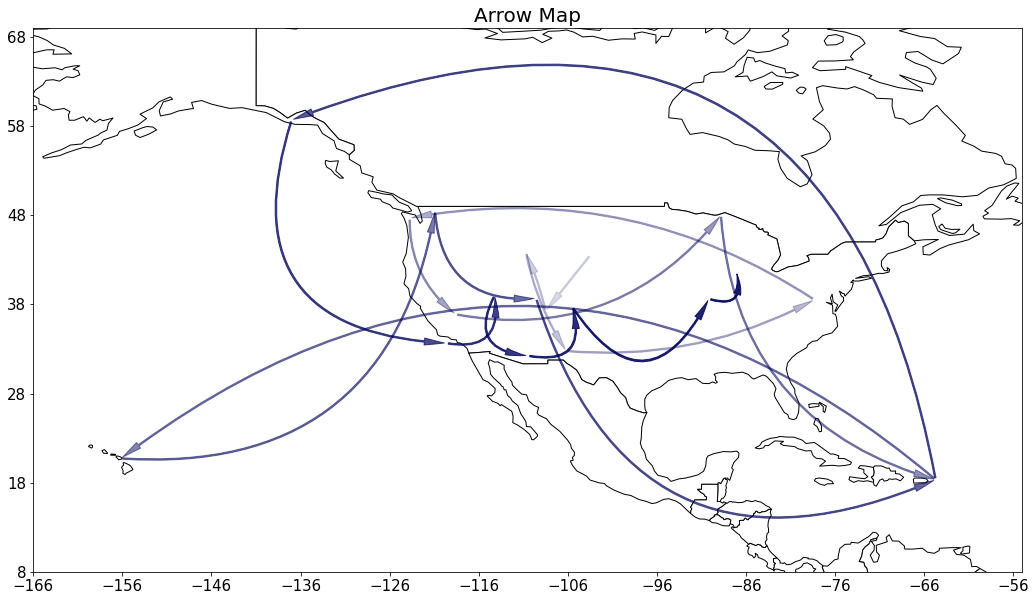

1903-01-01	Wind Cave National Park
1906-01-01	Mesa Verde National Park
1929-02-26	Grand Teton National Park
1933-01-18	White Sands National Park
1935-12-26	Shenandoah National Park
1938-06-29	Olympic National Park
1940-01-01	Kings Canyon National Park
1940-04-03	Isle Royale National Park
1956-08-02	Virgin Islands National Park
1961-07-01	Haleakalā National Park
1968-10-02	North Cascades National Park
1971-11-12	Arches National Park
1976-01-01	Virgin Islands National Park
1980-01-01	Glacier Bay National Park and Preserve
1980-01-01	Channel Islands National Park
1987-01-01	Great Basin National Park
1994-01-01	Saguaro National Park
2004-01-01	Great Sand Dunes National Park and Preserve
2018-02-22	Gateway Arch National Park


In [39]:
datetime_col_name = 'Inception_P571'
lon_lat_col_name = 'Lon_Lat_P625'
park_name_col_name = 'entity_subclass_P31Label'
parks.applyFunction(
    [datetime_col_name, lon_lat_col_name, park_name_col_name],
    createArrowMapVis
)

In [16]:
'''
Inputs:
- pandas dataframe df from KNP SPARQL relation
- string name of column that contains dates
- string name of column that contains coordinates
- string name of column that contains entity names
- string title for map
'''
def arrow_map(df):
    df = df.reset_index(drop=True)

    dates = df[df.columns[0]]
    lon_lats = df[df.columns[1]]
    
    date_parsed = [parse_date(x) for x in dates]
    lon_lat_parsed = [parse_lon_lat(x) for x in lon_lats]
    names = df[df.columns[2]]

    date_coords_list = [(date, coords, name) for date, coords, name in zip(date_parsed, lon_lat_parsed, names)]
    date_coords_list_sorted = sorted(date_coords_list)
    lats = [lat for lon, lat in lon_lat_parsed]
    lons = [lon for lon, lat in lon_lat_parsed]
    gdf = geopandas.GeoDataFrame(df,
                                 geometry=geopandas.points_from_xy(lats, lons))
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(
        color='white', edgecolor='black', figsize=(18, 10))
    gdf.plot(ax=ax, color='red')

    travel_log = []
    for ind in range(len(date_coords_list_sorted)-1):

        date, coords, name = date_coords_list_sorted[ind]
        travel_log.append(date + '\t' + name)

        _, coords_next, _ = date_coords_list_sorted[ind + 1]
        if coords_next==coords:
            continue
        x, y = coords
        x_next, y_next = coords_next

        style = "Simple, tail_width=1.5, head_width=7, head_length=20"
        base_alpha = 0.15
        kw = dict(arrowstyle=style, color='xkcd:dark blue',
                  alpha=((1-base_alpha)/(len(df)))*ind+base_alpha)
        rad = (1/len(date_coords_list_sorted))*ind
        a = patches.FancyArrowPatch((x, y), (x_next, y_next),
                                     connectionstyle="arc3,rad=%s" % str(rad), **kw)
        plt.gca().add_patch(a)

    if max(lons)-min(lons) <= 10:
        subdivision = 1
    elif max(lons)-min(lons) <= 20:
        subdivision = 2
    elif max(lons)-min(lons) <= 50:
        subdivision = 5
    else:
        subdivision = 10

    xmin = round(min(lons)-subdivision)
    xmax = round(max(lons)+subdivision)
    ymin = round(min(lats)-subdivision)
    ymax = round(max(lats)+subdivision)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xticks(np.arange(xmin, xmax+1, subdivision), fontsize=15)
    plt.yticks(np.arange(ymin, ymax+1, subdivision), fontsize=15)
    plt.title('Arrow Map', fontsize=20)
    plt.show()

    for t in travel_log:
        print(t)

In [7]:
import geopandas
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [6]:
'''
Input:
- string containing longitude, latitude, and other extraneous characters
    - currently supports input strings formatted in the way Wikidata longitude latitudes are formatted (e.g. the string `Point(-159.28 67.55)`)
- OR longitude latitude tuple
Output:
- (float longitude, float latitude) tuple
- OR string 'NA' if invalid input
'''
def parse_lon_lat(lon_lat):
    # if the input value is empty
    if lon_lat == 'NA':
        return 'NA'

    # if the input value looks like the format from wikidata
    if lon_lat[:6]=='Point(':
        entities = lon_lat[6:-1].split(' ')
        lon = float(entities[0])
        lat = float(entities[1])

    # if it has already been formatted as a tuple
    if len(lon_lat) == 2 and type(lon_lat) is tuple:
        lon, lat = lon_lat
        # if lon and lat values are valid
        if type(lon) is float and type(lat is float):
            if lon >= -180 and lon <= 180:
                if lat >= -90 and lat <= 90:
                    return lon_lat
        return 'NA' # if it is an invalid tuple

    return(lon, lat)

'''
Inputs:
- 20-character-string wikidata format
- OR the 10-character yyyy-mm-dd format
Output:
- 10-character yyyy-mm-dd format
- OR string 'NA' if invalid input
'''
def parse_date(date):
    # if the input value is empty
    if date=='NA':
        return 'NA'

    # if the input value looks like the format from wikidata
    if len(date)==20:
        return date[:10]

    # if it's already been formatted as a string
    if len(date)==10 and isinstance(date, str) and date[4]=='-' and date[-3]=='-':
        return date

    # if the input value is empty, an invalid string, or other
    return 'NA'